In [1]:
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn.linear_model import Ridge
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error, mean_absolute_error

In [2]:
VEHICLE_CATEGORIES = ["Category A", "Category B"]

# last N months used as test set
TEST_MONTHS = 12

# policy scenario: add X COEs
SCENARIO_ADDITIONAL_QUOTA = [50, 100, 200, 500]

# bootstrap configuration for elasticity confidence intervals
BOOTSTRAP_ITERATIONS = 300
RANDOM_SEED = 23


In [3]:
# utility helpers
def rmse(y_true, y_pred):
    return float(np.sqrt(mean_squared_error(y_true, y_pred)))

def safe_log(x):
    return np.log(np.maximum(np.asarray(x, dtype=float), 1e-9))

In [4]:
raw_bids = pd.read_csv("../data/COEBiddingResultsPrices.csv")
raw_bids.head()

,month,bidding_no,vehicle_class,quota,bids_success,bids_received,premium
0,2010-01,1,Category A,1152,1145,1342,18502
1,2010-01,1,Category B,687,679,883,19190
2,2010-01,1,Category C,173,173,265,19001
3,2010-01,1,Category D,373,365,509,889
4,2010-01,1,Category E,586,567,1011,19889


In [5]:
# standardise column types
raw_bids["month"] = raw_bids["month"].astype(str)
raw_bids["vehicle_class"] = raw_bids["vehicle_class"].astype(str)
raw_bids["bidding_no"] = raw_bids["bidding_no"].astype(int)

for col in ["quota", "bids_success", "bids_received", "premium"]:
    raw_bids[col] = pd.to_numeric(raw_bids[col], errors="coerce")

group_keys = ["month", "bidding_no", "vehicle_class"]

# weighted numerator = premium * quota
raw_bids["premium_x_quota"] = raw_bids["premium"] * raw_bids["quota"]

bidding_data = (
    raw_bids
    .groupby(group_keys, as_index=False)
    .agg(
        quota=("quota", "sum"),
        bids_success=("bids_success", "sum"),
        bids_received=("bids_received", "sum"),
        premium_x_quota=("premium_x_quota", "sum"),
    )
)

# quota-weighted premium
bidding_data["premium"] = bidding_data["premium_x_quota"] / bidding_data["quota"]
bidding_data = bidding_data.drop(columns=["premium_x_quota"])

# keep only Category A & B
bidding_data = bidding_data[bidding_data["vehicle_class"].isin(VEHICLE_CATEGORIES)].copy()

# time features
bidding_data["month_dt"] = pd.to_datetime(bidding_data["month"], format="%Y-%m")
bidding_data["year"] = bidding_data["month_dt"].dt.year
bidding_data["month_num"] = bidding_data["month_dt"].dt.month
bidding_data["quarter"] = bidding_data["month_dt"].dt.to_period("Q").astype(str)

# linear time trend
bidding_data["time_index"] = (
    (bidding_data["year"] - bidding_data["year"].min()) * 12
    + (bidding_data["month_num"] - 1)
)

# demand proxy
bidding_data["bid_pressure"] = bidding_data["bids_received"] / np.maximum(bidding_data["quota"], 1.0)

In [6]:
# quarterly quota totals
quarterly_quota = (
    bidding_data
    .groupby(["vehicle_class", "quarter"], as_index=False)
    .agg(quarter_quota_total=("quota", "sum"))
    .sort_values(["vehicle_class", "quarter"])
)

# Q on Q quota changes
quarterly_quota["previous_quarter_quota"] = (
    quarterly_quota
    .groupby("vehicle_class")["quarter_quota_total"]
    .shift(1)
)

quarterly_quota["quarter_quota_change_pct"] = (
    (quarterly_quota["quarter_quota_total"]
     - quarterly_quota["previous_quarter_quota"])
    / np.maximum(quarterly_quota["previous_quarter_quota"], 1.0)
)

# merge back into bidding-level data
bidding_data = bidding_data.merge(
    quarterly_quota,
    on=["vehicle_class", "quarter"],
    how="left"
)

bidding_data = bidding_data.sort_values(
    ["vehicle_class", "month_dt", "bidding_no"]
).reset_index(drop=True)


In [7]:
# coverage table 
coverage_table = (
    bidding_data
    .groupby("vehicle_class")
    .agg(
        start_month=("month_dt", "min"),
        end_month=("month_dt", "max"),
        observations=("month_dt", "size"),
        avg_quota=("quota", "mean"),
        avg_quarter_quota=("quarter_quota_total", "mean"),
        avg_price=("premium", "mean"),
        avg_bid_pressure=("bid_pressure", "mean"),
    )
    .reset_index()
)

coverage_table

,vehicle_class,start_month,end_month,observations,avg_quota,avg_quarter_quota,avg_price,avg_bid_pressure
0,Category A,2010-01-01,2025-11-01,376,1015.178191,6056.978723,59532.671727,1.31945
1,Category B,2010-01-01,2025-11-01,376,770.151596,4599.382979,71069.316635,1.37663


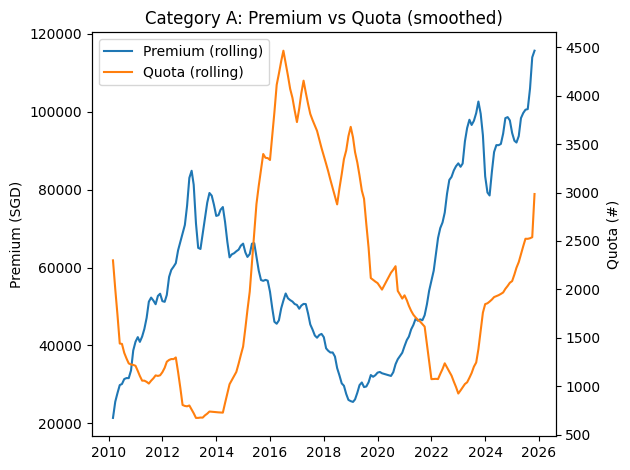

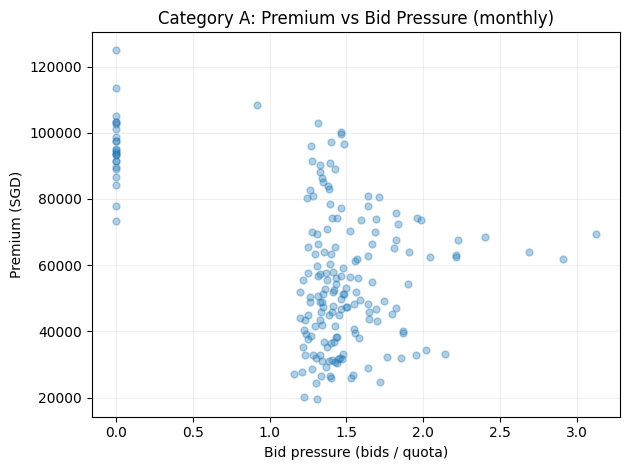

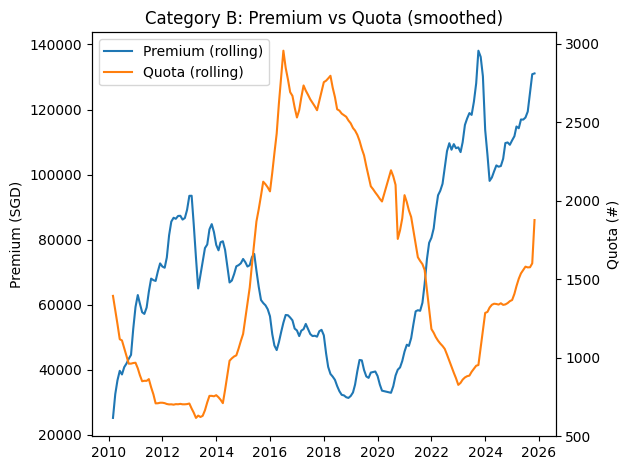

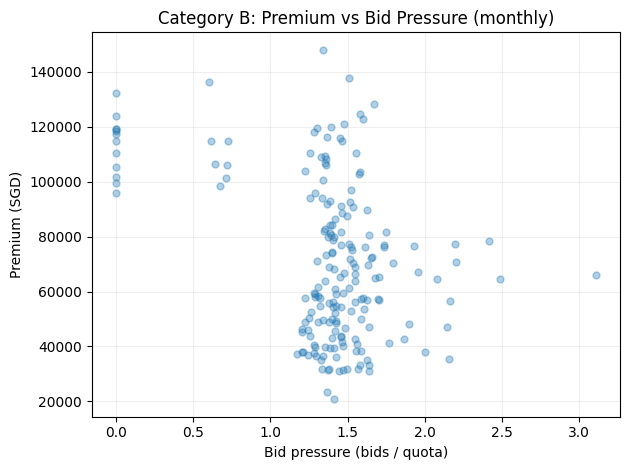

In [8]:
ROLLING_WINDOW = 3      

for category in VEHICLE_CATEGORIES:
    subset = bidding_data[bidding_data["vehicle_class"] == category].copy()

    # aggregate across bidding rounds monthly series
    monthly_view = (
        subset.groupby("month_dt", as_index=False)
              .agg(
                  premium=("premium", "mean"),
                  quota=("quota", "sum"),
                  bid_pressure=("bid_pressure", "mean"),
              )
              .sort_values("month_dt")
    )

    # smooth the series 
    monthly_view["premium_sm"] = monthly_view["premium"].rolling(ROLLING_WINDOW).mean()
    monthly_view["quota_sm"] = monthly_view["quota"].rolling(ROLLING_WINDOW).mean()

    fig, ax_left = plt.subplots()

    ax_left.plot(
        monthly_view["month_dt"], monthly_view["premium_sm"], label="Premium (rolling)"
    )
    ax_left.set_ylabel("Premium (SGD)")

    # quota 
    ax_right = ax_left.twinx()
    ax_right.plot(
        monthly_view["month_dt"], monthly_view["quota_sm"], label="Quota (rolling)", c="tab:orange"
    )
    ax_right.set_ylabel("Quota (#)")

    ax_left.xaxis.set_major_locator(mdates.YearLocator(2))   
    ax_left.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
    plt.setp(ax_left.get_xticklabels(), rotation=0)

    ax_left.set_title(f"{category}: Premium vs Quota (smoothed)")

    lines_left, labels_left = ax_left.get_legend_handles_labels()
    lines_right, labels_right = ax_right.get_legend_handles_labels()

    ax_left.legend(
        lines_left + lines_right,
        labels_left + labels_right
    )
    plt.tight_layout()
    plt.savefig(f"{category.replace(' ','_')}_premium_vs_quota.png")
    plt.show()

    # bid pressure vs premium 
    plt.figure()
    plt.scatter(
        monthly_view["bid_pressure"], monthly_view["premium"],
        alpha=0.35, s=25
    )
    plt.xlabel("Bid pressure (bids / quota)")
    plt.ylabel("Premium (SGD)")
    plt.title(f"{category}: Premium vs Bid Pressure (monthly)")
    plt.grid(True, alpha=0.2)

    plt.tight_layout()
    plt.savefig(f"{category.replace(' ','_')}_price_vs_bid_pressure.png")
    plt.show()

In [9]:
def build_model_matrix(data):
    data = data.sort_values(["month_dt", "bidding_no"]).copy()

    # price momentum (within bidding round)
    data["price_lag_1"] = data.groupby(
        ["vehicle_class", "bidding_no"]
    )["premium"].shift(1)

    data["price_lag_2"] = data.groupby(
        ["vehicle_class", "bidding_no"]
    )["premium"].shift(2)

    # log-transformed variables
    data["log_price"] = safe_log(data["premium"])
    data["log_quarter_quota"] = safe_log(data["quarter_quota_total"])
    data["quarter_quota_change_pct_filled"] = data["quarter_quota_change_pct"].fillna(0.0)
    data["log_bids_received"] = safe_log(data["bids_received"])
    data["log_price_lag_1"] = safe_log(data["price_lag_1"])
    data["log_price_lag_2"] = safe_log(data["price_lag_2"])

    # seasonality + bidding round
    month_dummies = pd.get_dummies(data["month_num"], prefix="month", drop_first=True)
    round_dummies = pd.get_dummies(data["bidding_no"], prefix="round", drop_first=True)

    feature_matrix = pd.concat([
        data[
            [
                "log_quarter_quota",
                "quarter_quota_change_pct_filled",
                "log_bids_received",
                "log_price_lag_1",
                "log_price_lag_2",
                "time_index",
            ]
        ],
        month_dummies,
        round_dummies,
    ], axis=1)

    target = data["log_price"]

    valid_rows = ~(
        data["price_lag_1"].isna()
        | data["price_lag_2"].isna()
        | data["quarter_quota_total"].isna()
    )

    return data[valid_rows], feature_matrix.loc[data[valid_rows].index], target.loc[data[valid_rows].index]

In [10]:
model_metrics = []
coefficients = []
all_predictions = []

for category in VEHICLE_CATEGORIES:
    category_data, X, y = build_model_matrix(
        bidding_data[bidding_data["vehicle_class"] == category]
    )

    # train test split, last N months as test
    cutoff_date = category_data["month_dt"].max() - pd.DateOffset(months=TEST_MONTHS - 1)
    train_data = category_data[category_data["month_dt"] < cutoff_date]
    test_data  = category_data[category_data["month_dt"] >= cutoff_date]

    model = Ridge(alpha=1.0)
    model.fit(X.loc[train_data.index], y.loc[train_data.index])

    train_predictions = np.exp(model.predict(X.loc[train_data.index]))
    test_predictions  = np.exp(model.predict(X.loc[test_data.index]))

    model_metrics.append({
        "vehicle_class": category,
        "MAPE_test": mean_absolute_percentage_error(test_data["premium"], test_predictions),
        "RMSE_test": rmse(test_data["premium"], test_predictions),
    })

    coef_table = pd.Series(model.coef_, index=X.columns).reset_index()
    coef_table.columns = ["feature", "coefficient"]
    coef_table["vehicle_class"] = category
    coefficients.append(coef_table)

    preds = pd.concat([
        train_data.assign(split="train", predicted_price=train_predictions),
        test_data.assign(split="test", predicted_price=test_predictions),
    ])
    preds["residual"] = preds["premium"] - preds["predicted_price"]
    all_predictions.append(preds)

metrics_df = pd.DataFrame(model_metrics)
coefficients_df = pd.concat(coefficients)
predictions_df = pd.concat(all_predictions)

metrics_df

,vehicle_class,MAPE_test,RMSE_test
0,Category A,0.052725,7795.496043
1,Category B,0.057970,8849.238822


In [11]:
rng = np.random.default_rng(RANDOM_SEED)
elasticity_results = []

for category in VEHICLE_CATEGORIES:
    category_data, X, y = build_model_matrix(
        bidding_data[bidding_data["vehicle_class"] == category]
    )

    # only use train data
    cutoff_date = category_data["month_dt"].max() - pd.DateOffset(months=TEST_MONTHS - 1)
    training_data = category_data[category_data["month_dt"] < cutoff_date]

    # fit Ridge due to correlations and lags
    base_model = Ridge(alpha=1.0).fit(
        X.loc[training_data.index],
        y.loc[training_data.index]
    )

    base_elasticity = pd.Series(
        base_model.coef_, index=X.columns
    )["log_quarter_quota"]

    bootstrap_samples = []

    # bootstrap over quarters
    quarters = training_data["quarter"].unique()
    for _ in range(BOOTSTRAP_ITERATIONS):
        # resample quarters with replacement
        sampled_quarters = rng.choice(quarters, size=len(quarters), replace=True)
        boot_data = pd.concat([
            training_data[training_data["quarter"] == q] for q in sampled_quarters
        ])

        boot_model = Ridge(alpha=1.0).fit(
            X.loc[boot_data.index],
            y.loc[boot_data.index]
        )

        bootstrap_samples.append(
            pd.Series(boot_model.coef_, index=X.columns)["log_quarter_quota"]
        )

    ci_low, ci_high = np.percentile(bootstrap_samples, [2.5, 97.5])

    elasticity_results.append({
        "vehicle_class": category,
        "elasticity": base_elasticity,
        "ci_low": ci_low,
        "ci_high": ci_high,
    })

elasticity_df = pd.DataFrame(elasticity_results)
elasticity_df

,vehicle_class,elasticity,ci_low,ci_high
0,Category A,-0.062857,-0.098331,-0.040559
1,Category B,-0.135050,-0.224790,-0.092375


In [12]:
scenario_results = []

for category in VEHICLE_CATEGORIES:
    elasticity = elasticity_df.loc[
        elasticity_df["vehicle_class"] == category, "elasticity"
    ].iloc[0]

    recent_data = bidding_data[
        (bidding_data["vehicle_class"] == category)
        & (bidding_data["month_dt"]
           >= bidding_data["month_dt"].max() - pd.DateOffset(months=5))
    ]

    baseline_price = recent_data["premium"].mean()
    baseline_quarter_quota = recent_data.groupby("quarter")["quota"].sum().mean()

    for additional_quota in SCENARIO_ADDITIONAL_QUOTA:
        pct_change = np.exp(
            elasticity * np.log(1 + additional_quota / baseline_quarter_quota)
        ) - 1

        scenario_results.append({
            "vehicle_class": category,
            "additional_quota": additional_quota,
            "predicted_price": baseline_price * (1 + pct_change),
        })

scenario_df = pd.DataFrame(scenario_results)
scenario_df

,vehicle_class,additional_quota,predicted_price
0,Category A,50,108070.889694
1,Category A,100,108010.066352
2,Category A,200,107890.130361
3,Category A,500,107543.292221
4,Category B,50,124998.214856
5,Category B,100,124759.082975
6,Category B,200,124292.081597
7,Category B,500,122973.714667


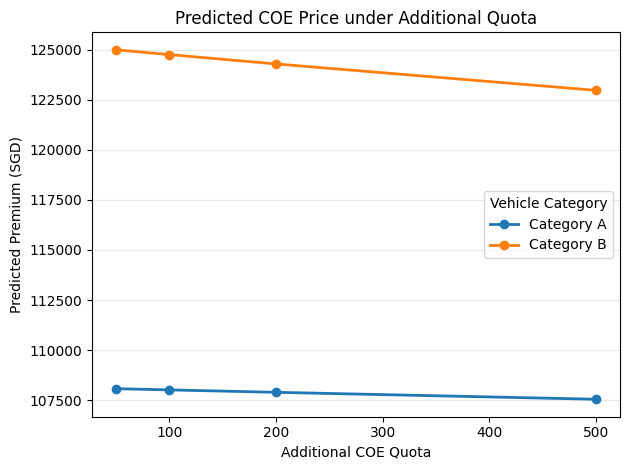

In [13]:
plt.figure()

for category in VEHICLE_CATEGORIES:
    subset = scenario_df[scenario_df["vehicle_class"] == category].sort_values("additional_quota")
    plt.plot(
        subset["additional_quota"],
        subset["predicted_price"],
        marker="o",
        linewidth=2,
        label=category
    )

plt.title("Predicted COE Price under Additional Quota")
plt.xlabel("Additional COE Quota")
plt.ylabel("Predicted Premium (SGD)")
plt.legend(title="Vehicle Category")
plt.grid(axis="y", alpha=0.3)

plt.tight_layout()
plt.savefig("predicted_price_under_additional_quota.png")
plt.show()